In [1]:
from datasets import load_dataset

ds = load_dataset("scene_parse_150", split="train[:50]")

No config specified, defaulting to: scene_parse_150/scene_parsing


Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/20210 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3352 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset scene_parse_150 downloaded and prepared to /home/bcp/.cache/huggingface/datasets/scene_parse_150/scene_parsing/1.0.0/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75. Subsequent calls will reuse this data.


In [2]:
ds = ds.train_test_split(test_size=0.2)
train_ds = ds['train']
test_ds = ds['test']

In [3]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x512>,
 'annotation': <PIL.PngImagePlugin.PngImageFile image mode=L size=768x512>,
 'scene_category': 19}

In [6]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.
Token has not been saved to git credential helper.
Your token has been saved to /home/bcp/.huggingface/token
Login successful


In [8]:
import json
from huggingface_hub import cached_download, hf_hub_url

repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(cached_download(hf_hub_url(repo_id, filename, repo_type="dataset")), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

Downloading:   0%|          | 0.00/2.81k [00:00<?, ?B/s]

In [12]:
id2label

{0: 'wall',
 1: 'building',
 2: 'sky',
 3: 'floor',
 4: 'tree',
 5: 'ceiling',
 6: 'road',
 7: 'bed ',
 8: 'windowpane',
 9: 'grass',
 10: 'cabinet',
 11: 'sidewalk',
 12: 'person',
 13: 'earth',
 14: 'door',
 15: 'table',
 16: 'mountain',
 17: 'plant',
 18: 'curtain',
 19: 'chair',
 20: 'car',
 21: 'water',
 22: 'painting',
 23: 'sofa',
 24: 'shelf',
 25: 'house',
 26: 'sea',
 27: 'mirror',
 28: 'rug',
 29: 'field',
 30: 'armchair',
 31: 'seat',
 32: 'fence',
 33: 'desk',
 34: 'rock',
 35: 'wardrobe',
 36: 'lamp',
 37: 'bathtub',
 38: 'railing',
 39: 'cushion',
 40: 'base',
 41: 'box',
 42: 'column',
 43: 'signboard',
 44: 'chest of drawers',
 45: 'counter',
 46: 'sand',
 47: 'sink',
 48: 'skyscraper',
 49: 'fireplace',
 50: 'refrigerator',
 51: 'grandstand',
 52: 'path',
 53: 'stairs',
 54: 'runway',
 55: 'case',
 56: 'pool table',
 57: 'pillow',
 58: 'screen door',
 59: 'stairway',
 60: 'river',
 61: 'bridge',
 62: 'bookcase',
 63: 'blind',
 64: 'coffee table',
 65: 'toilet',
 66: '

In [13]:
label2id

{'wall': 0,
 'building': 1,
 'sky': 2,
 'floor': 3,
 'tree': 4,
 'ceiling': 5,
 'road': 6,
 'bed ': 7,
 'windowpane': 8,
 'grass': 9,
 'cabinet': 10,
 'sidewalk': 11,
 'person': 12,
 'earth': 13,
 'door': 14,
 'table': 15,
 'mountain': 16,
 'plant': 17,
 'curtain': 18,
 'chair': 19,
 'car': 20,
 'water': 21,
 'painting': 22,
 'sofa': 23,
 'shelf': 24,
 'house': 25,
 'sea': 26,
 'mirror': 27,
 'rug': 28,
 'field': 29,
 'armchair': 30,
 'seat': 31,
 'fence': 32,
 'desk': 33,
 'rock': 34,
 'wardrobe': 35,
 'lamp': 36,
 'bathtub': 37,
 'railing': 38,
 'cushion': 39,
 'base': 40,
 'box': 41,
 'column': 42,
 'signboard': 43,
 'chest of drawers': 44,
 'counter': 45,
 'sand': 46,
 'sink': 47,
 'skyscraper': 48,
 'fireplace': 49,
 'refrigerator': 50,
 'grandstand': 51,
 'path': 52,
 'stairs': 53,
 'runway': 54,
 'case': 55,
 'pool table': 56,
 'pillow': 57,
 'screen door': 58,
 'stairway': 59,
 'river': 60,
 'bridge': 61,
 'bookcase': 62,
 'blind': 63,
 'coffee table': 64,
 'toilet': 65,
 'flow

In [9]:
num_labels

150

In [15]:
from transformers import AutoImageProcessor

feature_extractor = AutoImageProcessor.from_pretrained("nvidia/mit-b0", do_reduce_labels=True)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [17]:
from torchvision.transforms import ColorJitter

jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

In [27]:
def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = feature_extractor(images, labels)
    return inputs

def val_transforms(example_batch):
    images = [x for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = feature_extractor(images, labels)
    return inputs

In [28]:
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

In [29]:
import evaluate

metric = evaluate.load("mean_iou")

In [45]:
import torch
from torch import nn
import numpy as np

def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)
        
        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            ignore_index=255,
            reduce_labels=False,
        )
        
        for key, value in metrics.items():
            if type(value) is np.ndarray:
                metrics[key] = value.tolist()
        return metrics

In [46]:
from transformers import AutoModelForSemanticSegmentation, TrainingArguments, Trainer

pretrained_model_name = "nvidia/mit-b0"
model = AutoModelForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id,
)

loading configuration file config.json from cache at /home/bcp/.cache/huggingface/hub/models--nvidia--mit-b0/snapshots/ed0b85c75627eab6a3c6989627450cf95f115381/config.json
Model config SegformerConfig {
  "_name_or_path": "nvidia/mit-b0",
  "architectures": [
    "SegformerForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout_prob": 0.1,
  "decoder_hidden_size": 256,
  "depths": [
    2,
    2,
    2,
    2
  ],
  "downsampling_rates": [
    1,
    4,
    8,
    16
  ],
  "drop_path_rate": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_sizes": [
    32,
    64,
    160,
    256
  ],
  "id2label": {
    "0": "wall",
    "1": "building",
    "2": "sky",
    "3": "floor",
    "4": "tree",
    "5": "ceiling",
    "6": "road",
    "7": "bed ",
    "8": "windowpane",
    "9": "grass",
    "10": "cabinet",
    "11": "sidewalk",
    "12": "person",
    "13": "earth",
    "14": "door",
    "15": "table",
    "16": "mountain",
    "17": "

In [47]:
training_args = TrainingArguments(
    output_dir="segformer-b0-scene-parse-150",
    learning_rate=6e-5,
    num_train_epochs=50,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    remove_unused_columns=False,
    push_to_hub=False,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [48]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [49]:
trainer.train()

***** Running training *****
  Num examples = 40
  Num Epochs = 50
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 1000
  Number of trainable parameters = 3752694


Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Per Category Iou,Per Category Accuracy
20,4.794200,4.922507,0.004872,0.042567,0.047902,"[0.04962934061646508, 0.021680245725104644, 0.05864511987561911, 0.001955473399999144, 0.09685892384668114, 0.19954142447105588, 0.04603463992707384, 0.0032891093933420453, 0.03000327457294111, 0.0, 0.018397546396830017, 0.0, 0.007084928199998347, nan, 0.0, 0.0, 0.0, 0.000433304446370242, nan, 0.021779336999162333, 0.0, 0.0, 0.0, 0.004104883314161453, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.01063562072025536, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, nan, 0.0, 0.0, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, nan, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, nan, nan, 0.0, nan, nan, 0.0, 0.0, 0.0, nan, nan, 0.0, nan, nan, 0.0, 0.0, nan, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0]","[0.05241087678734981, 0.022057226744034538, 0.05932324556177767, 0.0026649871998973658, 0.2777594062316285, 0.3139011886359071, 0.04945819837844266, 0.0033447452587954413, 0.2845055115665269, 0.0, 0.5793035387001269, 0.0, 0.007267207679327041, nan, 0.0, 0.0, nan, 0.0006980240549828179, nan, 0.13119504396482815, 0.0, nan, 0.0, 0.014608568864961867, 0.0, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.031886590160028594, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, 0.0, nan, nan, 0.0]"
40,4.475600,4.676464,0.021290,0.105226,0.243794,"[0.20407644179999318, 0.22125956404017524, 0.4026371570334056, 0.28808970246328613, 0.1501604053201663, 0.29472907423572925, 0.017617520879178283, 0.002495760407000928, 0.0071832320152573105, 0.0, 0.021764849316800478, 0.004602757119535643, 0.03365008649494064, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.05312625653397668, 0.0, nan, 0.0, 0.0564495495616811, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, nan, 0.009268892461931334, 0.0, 0.0, nan, 0.0, nan, 0.0, 0.0, 0.0, nan, 0.0, 0.0, nan, 0.0, 0.0, nan, nan, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, nan, 0.0, 0.0, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, 0.0, 0.0, nan, 0.0, nan, 0.0, 0.0]","[0.42315779064374026, 0.24862318777633968, 0.4051173597045157, 0.6850125085285422, 0.8134736919459141, 0.5720474056995135, 0.01887386410538024, 0.002635253840263075, 0.029627904569683797, 0.0, 0.6795432116170873, 0.006016597510373444, 0.03612404284006207, nan, 0.0, 0.0, nan, 0.0, nan, 0.47526978417266186, 0.0, nan, 0.0, 0.11754149842978914, 0.0, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.011674542349998015, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
Saving model checkpoint to segformer-b0-scene-parse-150/checkpoint-20
Configuration saved in segformer-b0-scene-parse-150/checkpoint-20/config.json
Model weights saved in segformer-b0-scene-parse-150/checkpoint-20/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
/home/bcp/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/home/bcp/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to segformer-b0-scene-parse-150/checkpoint-40
Configuration saved in

Saving model checkpoint to segformer-b0-scene-parse-150/checkpoint-200
Configuration saved in segformer-b0-scene-parse-150/checkpoint-200/config.json
Model weights saved in segformer-b0-scene-parse-150/checkpoint-200/pytorch_model.bin
Deleting older checkpoint [segformer-b0-scene-parse-150/checkpoint-140] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
/home/bcp/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/home/bcp/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to segformer-b0-scene-parse-150/

Saving model checkpoint to segformer-b0-scene-parse-150/checkpoint-380
Configuration saved in segformer-b0-scene-parse-150/checkpoint-380/config.json
Model weights saved in segformer-b0-scene-parse-150/checkpoint-380/pytorch_model.bin
Deleting older checkpoint [segformer-b0-scene-parse-150/checkpoint-320] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
/home/bcp/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/home/bcp/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to segformer-b0-scene-parse-150/

Saving model checkpoint to segformer-b0-scene-parse-150/checkpoint-560
Configuration saved in segformer-b0-scene-parse-150/checkpoint-560/config.json
Model weights saved in segformer-b0-scene-parse-150/checkpoint-560/pytorch_model.bin
Deleting older checkpoint [segformer-b0-scene-parse-150/checkpoint-500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
/home/bcp/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/home/bcp/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to segformer-b0-scene-parse-150/

Saving model checkpoint to segformer-b0-scene-parse-150/checkpoint-740
Configuration saved in segformer-b0-scene-parse-150/checkpoint-740/config.json
Model weights saved in segformer-b0-scene-parse-150/checkpoint-740/pytorch_model.bin
Deleting older checkpoint [segformer-b0-scene-parse-150/checkpoint-680] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
/home/bcp/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/home/bcp/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to segformer-b0-scene-parse-150/

Saving model checkpoint to segformer-b0-scene-parse-150/checkpoint-920
Configuration saved in segformer-b0-scene-parse-150/checkpoint-920/config.json
Model weights saved in segformer-b0-scene-parse-150/checkpoint-920/pytorch_model.bin
Deleting older checkpoint [segformer-b0-scene-parse-150/checkpoint-860] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
/home/bcp/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/home/bcp/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to segformer-b0-scene-parse-150/

TrainOutput(global_step=1000, training_loss=2.362781359732151, metrics={'train_runtime': 862.4162, 'train_samples_per_second': 2.319, 'train_steps_per_second': 1.16, 'total_flos': 3.5414863773696e+16, 'train_loss': 2.362781359732151, 'epoch': 50.0})

No config specified, defaulting to: scene_parse_150/scene_parsing
Found cached dataset scene_parse_150 (/home/bcp/.cache/huggingface/datasets/scene_parse_150/scene_parsing/1.0.0/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75)


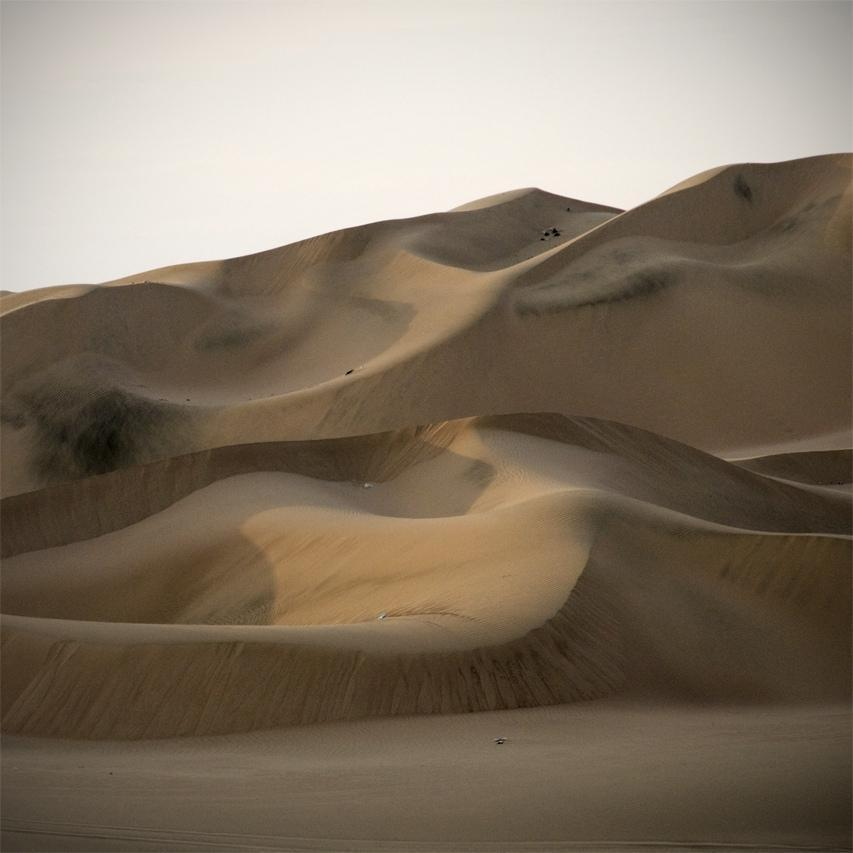

In [60]:
ds = load_dataset("scene_parse_150", split="test[:50]")
image = ds[0]["image"]
image

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoding = feature_extractor(image, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)

In [66]:
outputs = model(pixel_values=pixel_values)
logits = outputs.logits.cpu()

In [67]:
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

In [68]:
def create_ade20k_label_colormap():
  """Creates a label colormap used in ADE20K segmentation benchmark.
  Returns:
    A colormap for visualizing segmentation results.
  """
  return np.asarray([
      [0, 0, 0],
      [120, 120, 120],
      [180, 120, 120],
      [6, 230, 230],
      [80, 50, 50],
      [4, 200, 3],
      [120, 120, 80],
      [140, 140, 140],
      [204, 5, 255],
      [230, 230, 230],
      [4, 250, 7],
      [224, 5, 255],
      [235, 255, 7],
      [150, 5, 61],
      [120, 120, 70],
      [8, 255, 51],
      [255, 6, 82],
      [143, 255, 140],
      [204, 255, 4],
      [255, 51, 7],
      [204, 70, 3],
      [0, 102, 200],
      [61, 230, 250],
      [255, 6, 51],
      [11, 102, 255],
      [255, 7, 71],
      [255, 9, 224],
      [9, 7, 230],
      [220, 220, 220],
      [255, 9, 92],
      [112, 9, 255],
      [8, 255, 214],
      [7, 255, 224],
      [255, 184, 6],
      [10, 255, 71],
      [255, 41, 10],
      [7, 255, 255],
      [224, 255, 8],
      [102, 8, 255],
      [255, 61, 6],
      [255, 194, 7],
      [255, 122, 8],
      [0, 255, 20],
      [255, 8, 41],
      [255, 5, 153],
      [6, 51, 255],
      [235, 12, 255],
      [160, 150, 20],
      [0, 163, 255],
      [140, 140, 140],
      [250, 10, 15],
      [20, 255, 0],
      [31, 255, 0],
      [255, 31, 0],
      [255, 224, 0],
      [153, 255, 0],
      [0, 0, 255],
      [255, 71, 0],
      [0, 235, 255],
      [0, 173, 255],
      [31, 0, 255],
      [11, 200, 200],
      [255, 82, 0],
      [0, 255, 245],
      [0, 61, 255],
      [0, 255, 112],
      [0, 255, 133],
      [255, 0, 0],
      [255, 163, 0],
      [255, 102, 0],
      [194, 255, 0],
      [0, 143, 255],
      [51, 255, 0],
      [0, 82, 255],
      [0, 255, 41],
      [0, 255, 173],
      [10, 0, 255],
      [173, 255, 0],
      [0, 255, 153],
      [255, 92, 0],
      [255, 0, 255],
      [255, 0, 245],
      [255, 0, 102],
      [255, 173, 0],
      [255, 0, 20],
      [255, 184, 184],
      [0, 31, 255],
      [0, 255, 61],
      [0, 71, 255],
      [255, 0, 204],
      [0, 255, 194],
      [0, 255, 82],
      [0, 10, 255],
      [0, 112, 255],
      [51, 0, 255],
      [0, 194, 255],
      [0, 122, 255],
      [0, 255, 163],
      [255, 153, 0],
      [0, 255, 10],
      [255, 112, 0],
      [143, 255, 0],
      [82, 0, 255],
      [163, 255, 0],
      [255, 235, 0],
      [8, 184, 170],
      [133, 0, 255],
      [0, 255, 92],
      [184, 0, 255],
      [255, 0, 31],
      [0, 184, 255],
      [0, 214, 255],
      [255, 0, 112],
      [92, 255, 0],
      [0, 224, 255],
      [112, 224, 255],
      [70, 184, 160],
      [163, 0, 255],
      [153, 0, 255],
      [71, 255, 0],
      [255, 0, 163],
      [255, 204, 0],
      [255, 0, 143],
      [0, 255, 235],
      [133, 255, 0],
      [255, 0, 235],
      [245, 0, 255],
      [255, 0, 122],
      [255, 245, 0],
      [10, 190, 212],
      [214, 255, 0],
      [0, 204, 255],
      [20, 0, 255],
      [255, 255, 0],
      [0, 153, 255],
      [0, 41, 255],
      [0, 255, 204],
      [41, 0, 255],
      [41, 255, 0],
      [173, 0, 255],
      [0, 245, 255],
      [71, 0, 255],
      [122, 0, 255],
      [0, 255, 184],
      [0, 92, 255],
      [184, 255, 0],
      [0, 133, 255],
      [255, 214, 0],
      [25, 194, 194],
      [102, 255, 0],
      [92, 0, 255],
  ])

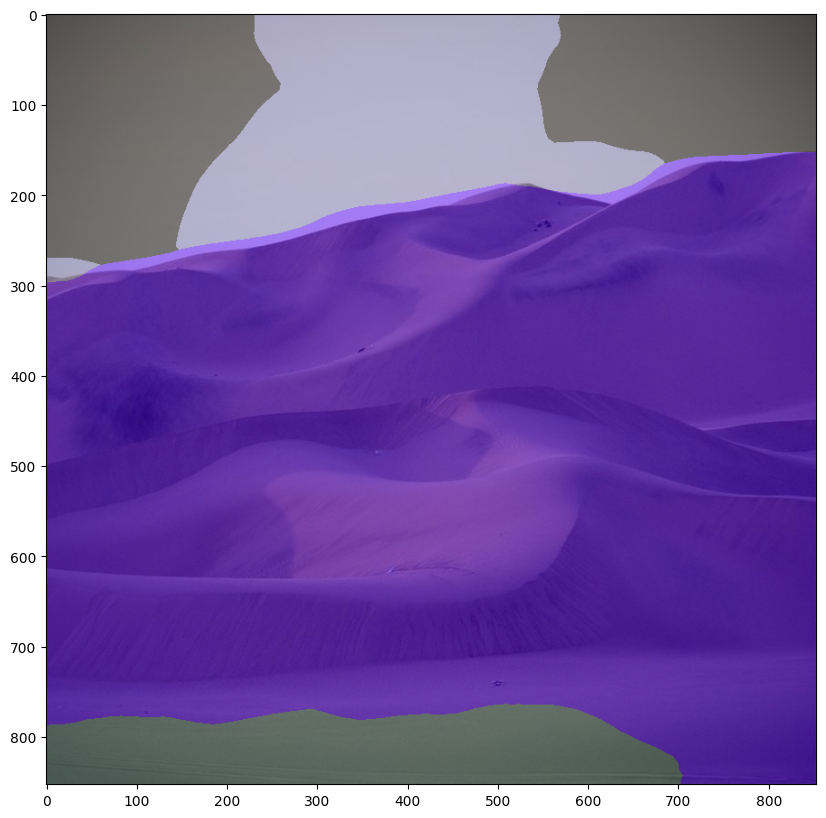

In [70]:
import matplotlib.pyplot as plt

color_seg = np.zeros(
    (pred_seg.shape[0], pred_seg.shape[1], 3),
    dtype=np.uint8
)
palette = np.array(create_ade20k_label_colormap())
for label, color in enumerate(palette):
    color_seg[pred_seg == label, :] = color
color_seg = color_seg[..., ::-1]

img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()